In [1]:
import ecmwf.data as ecdata
from ecmwf.opendata import Client
import numpy as np
import time
import json
import os
from datetime import datetime

In [2]:
def get_date_from_offset(date_string, offset_hours):
    date_format = "%Y%m%d"
    date = datetime.strptime(date_string, date_format)
    result_date = date + timedelta(hours=offset_hours)
    return result_date

def date_to_time_str(date_time):
    date_format = "%Y-%m-%d %H:%M:%S"
    time_str = date_time.strftime(date_format)
    return time_str

def date_to_day_str(date_time):
    date_format = "%m-%d-%Y"
    month_day_year = date_time.strftime(date_format)
    return month_day_year

def date_to_short_str(date_time):
    date_format = "%Y%m%d_%H"
    folder_str = date_time.strftime(date_format)
    return folder_str

def short_str_to_date(short_str):
    return datetime.strptime(short_str, "%Y%m%d_%H")

def short_str_date_hour(short_str):
    return short_str[-2:]

def short_str_no_hour(short_str):
    return short_str[0:-3]

def short_str_no_hour_to_date(short_str):
    return datetime.strptime(short_str, "%Y%m%d")

In [3]:
def retrieve_all_steps_2t(d, t):
    # d should be 0 (for today), or -1, -2 (for yesterday, day before yesterday)
    # only use t = 0 or t = 12 (as that is the only one that has 'oper' forecasts)
    # oper forecasts go from 0 to 144 every 3 hours, then 150 to 240 every 6 hours
    steps3 = list(range(0,147, 3))
    steps6 = list(range(150,246,6))
    steps = steps3 + steps6
    averages = {}
    for step in steps:
        parameters = ['2t']
        output_filename = '2t.grib'
        time.sleep(1)
        client.retrieve(
            date=d,
            time=t,
            step=step,
            stream="oper",
            type="fc",
            levtype="sfc",
            param=parameters,
            target=output_filename
        )
        data = ecdata.read(output_filename)
        # describe = data.describe()
        t2m = data.select(shortName="2t")
        # convert from kelvin to celsius
        t2m -= 273.15
        average = np.average(t2m.values())
        base_date = date_to_short_str(t2m.base_date())
        valid_date = date_to_short_str(t2m.valid_date())
        if base_date not in averages:
            averages[base_date] = {}
        averages[base_date][valid_date] = average
    return averages

def write_averages(averages_data_folder, averages):
    # write the data for the averages so we don't have to compute again
    if not os.path.exists(averages_data_folder):
        os.makedirs(averages_data_folder)
    for base_date, data in averages.items():
        file_path = os.path.join(averages_data_folder, base_date)
        with open(file_path, 'w') as f:
            json_object = json.dumps(data, indent=4)
            f.write(json_object)

In [4]:
# Compute day averages and graph them
def process_file(file_path):
    with open(file_path, 'r') as f:
        forecast_temperatures = json.load(f)
    
    last_date = None
    complete_averages = {}
    
    # calculate the average for each day
    last_day_str = None
    day_averages = []
    last_avg = None
    first_day = True
    first_hour = None
    for valid_time, avg in forecast_temperatures.items():
        # handle case for first observation
        if last_day_str is None:
            last_day_str = short_str_no_hour(valid_time)
            first_hour = short_str_date_hour(valid_time)

        day_str = short_str_no_hour(valid_time)
        if day_str == last_day_str:
            # time step in same day
            day_averages.append(avg)
        else:
            # time step goes to next day
            # print out the previous day's average first
            
            day_average = np.average(day_averages)
            if last_avg == None:
                last_avg = day_average
            day_over_day_delta = day_average - last_avg
            print(f"Global 2m temp average (C) for {last_day_str}: {day_average:6.3f} (day over day delta: {day_over_day_delta:6.3f})")
            # don't include non-complete days
            if not first_day or first_hour == '00':
                complete_averages[last_day_str] = day_average
            # clear the list for the new day
            day_averages = []
            # change the last_day
            last_day_str = day_str
            # add the current day's average to the list
            day_averages.append(avg)
            last_avg = day_average
            # set first day done
            first_day = False
    return complete_averages

In [9]:
client = Client("ecmwf", beta=True)
parameters = ['2t']
# temporary output
output_filename = '2t.grib'
# where to store the averages (in a single file for each base_date) for the forecast
averages_data_folder = 'data'

## ONLY USE t = 0 or t = 12
# d can be 0 (today), or past day forecasts (-1 or -2 or -3)
d = 0
t = 0
averages = retrieve_all_steps_2t(d, t)
# store the data for use later
write_averages(averages_data_folder, averages)

20230809000000-0h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-3h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-6h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-9h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-12h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-15h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-18h-oper-fc.grib2:   0%|          | 0.00/283k [00:00<?, ?B/s]

20230809000000-21h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-24h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-27h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-30h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-33h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-36h-oper-fc.grib2:   0%|          | 0.00/235k [00:00<?, ?B/s]

20230809000000-39h-oper-fc.grib2:   0%|          | 0.00/236k [00:00<?, ?B/s]

20230809000000-42h-oper-fc.grib2:   0%|          | 0.00/284k [00:00<?, ?B/s]

20230809000000-45h-oper-fc.grib2:   0%|          | 0.00/283k [00:00<?, ?B/s]

20230809000000-48h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-51h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-54h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-57h-oper-fc.grib2:   0%|          | 0.00/235k [00:00<?, ?B/s]

20230809000000-60h-oper-fc.grib2:   0%|          | 0.00/235k [00:00<?, ?B/s]

20230809000000-63h-oper-fc.grib2:   0%|          | 0.00/235k [00:00<?, ?B/s]

20230809000000-66h-oper-fc.grib2:   0%|          | 0.00/236k [00:00<?, ?B/s]

20230809000000-69h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-72h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-75h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-78h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-81h-oper-fc.grib2:   0%|          | 0.00/234k [00:00<?, ?B/s]

20230809000000-84h-oper-fc.grib2:   0%|          | 0.00/235k [00:00<?, ?B/s]

20230809000000-87h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-90h-oper-fc.grib2:   0%|          | 0.00/283k [00:00<?, ?B/s]

20230809000000-93h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-96h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-99h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-102h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-105h-oper-fc.grib2:   0%|          | 0.00/234k [00:00<?, ?B/s]

20230809000000-108h-oper-fc.grib2:   0%|          | 0.00/235k [00:00<?, ?B/s]

20230809000000-111h-oper-fc.grib2:   0%|          | 0.00/235k [00:00<?, ?B/s]

20230809000000-114h-oper-fc.grib2:   0%|          | 0.00/283k [00:00<?, ?B/s]

20230809000000-117h-oper-fc.grib2:   0%|          | 0.00/283k [00:00<?, ?B/s]

20230809000000-120h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-123h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-126h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-129h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-132h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-135h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-138h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-141h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-144h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-150h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-156h-oper-fc.grib2:   0%|          | 0.00/281k [00:00<?, ?B/s]

20230809000000-162h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-168h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-174h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-180h-oper-fc.grib2:   0%|          | 0.00/234k [00:00<?, ?B/s]

20230809000000-186h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-192h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-198h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

20230809000000-204h-oper-fc.grib2:   0%|          | 0.00/234k [00:00<?, ?B/s]

20230809000000-210h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-216h-oper-fc.grib2:   0%|          | 0.00/232k [00:00<?, ?B/s]

20230809000000-222h-oper-fc.grib2:   0%|          | 0.00/279k [00:00<?, ?B/s]

20230809000000-228h-oper-fc.grib2:   0%|          | 0.00/234k [00:00<?, ?B/s]

20230809000000-234h-oper-fc.grib2:   0%|          | 0.00/282k [00:00<?, ?B/s]

20230809000000-240h-oper-fc.grib2:   0%|          | 0.00/280k [00:00<?, ?B/s]

In [10]:
# Get a list of all items in the data directory
items = os.listdir(averages_data_folder)
# Filter out only the filenames
sorted_files = sorted(os.path.join(averages_data_folder, item) for item in items if os.path.isfile(os.path.join(averages_data_folder, item)))
complete_day_averages = {}

# file path is the short string that is the base date
for file_path in sorted_files:
    print(f"-- Processing {file_path}")
    base_date_short_str = os.path.basename(file_path)
    complete_day_averages[base_date_short_str] = process_file(file_path)

-- Processing data/20230805_00
Global 2m temp average (C) for 20230805:  8.712 (day over day delta:  0.000)
Global 2m temp average (C) for 20230806:  8.561 (day over day delta: -0.151)
Global 2m temp average (C) for 20230807:  8.420 (day over day delta: -0.141)
Global 2m temp average (C) for 20230808:  8.350 (day over day delta: -0.070)
Global 2m temp average (C) for 20230809:  8.276 (day over day delta: -0.074)
Global 2m temp average (C) for 20230810:  8.126 (day over day delta: -0.150)
Global 2m temp average (C) for 20230811:  8.004 (day over day delta: -0.122)
Global 2m temp average (C) for 20230812:  7.941 (day over day delta: -0.063)
Global 2m temp average (C) for 20230813:  8.006 (day over day delta:  0.065)
Global 2m temp average (C) for 20230814:  8.193 (day over day delta:  0.187)
-- Processing data/20230805_12
Global 2m temp average (C) for 20230805:  8.777 (day over day delta:  0.000)
Global 2m temp average (C) for 20230806:  8.561 (day over day delta: -0.216)
Global 2m temp

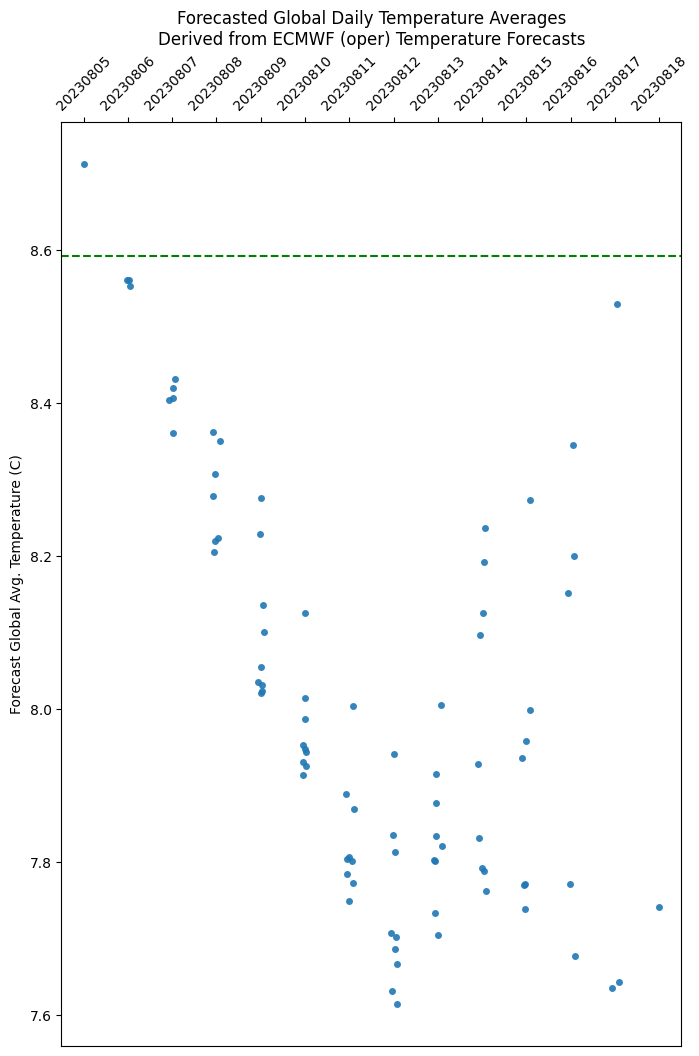

In [11]:
# strip plot for each day

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def graph_strip_plot(forecast, record):
    fig, ax = plt.subplots(figsize=(8, 12))
    # Create a list of all data points and their corresponding labels
    data = []
    labels = []
    hue = []

    for date, temps in forecast.items():
        data.extend(temps)
        # treat the date as a whole string
        labels.extend([date] * len(temps))
        #hue.extend(['Forecast'] * len(temps))

    #print(labels)
    #print(data)
    # Set the style of the strip plot
    sns.stripplot(x=labels, y=data, dodge=True, alpha=0.9, linewidth=0)

    # Add a horizontal line at the rise threshold
    ax.axhline(y=record, color='g', linestyle='--')

    # Set the y-axis label
    ax.set_ylabel('Forecast Global Avg. Temperature (C)')

    # Move the legend to the right of the chart
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Set the x-axis to be at the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set more subticks on the y-axis
    #plt.yticks(np.arange(-1.0, 1.6, 0.1))

    # Increase spacing between each day
    #plt.subplots_adjust(wspace=0.6)
        
    # Add a title to the chart
    plt.title('Forecasted Global Daily Temperature Averages' + '\n' + 
              'Derived from ECMWF (oper) Temperature Forecasts'
    )

    # Show the plot
    plt.show()

forecast = {}
# exclude forecasts (base date) older than this day, or set to None for ALL
min_forecast_day = "2023-08-01"

# append all the (valid forecast) days' data from all (base day) forecasts
for base_date_short, complete_day_average in complete_day_averages.items():
    # each forecast has a set of forecast dates
    # use if want to prune old forecasts
    base_day = short_str_to_date(base_date_short)

    # Date to compare in the format YYYY-MM-DD
    if min_forecast_day:
        compare_day = datetime.strptime(min_forecast_day, "%Y-%m-%d")
    else:
        compare_day = None

    # Compare the dates
    if not compare_day or compare_day <= base_day:
        for valid_day, forecast_average in complete_day_average.items():
            day_str = valid_day
            if day_str not in forecast:
                forecast[day_str] = []
            temps = forecast[day_str]
            temps.append(forecast_average)
            forecast[day_str] = temps

#print(forecast)
# CFSR record was on August 2. GEFS forecast from previous day was 8.592
record = 8.592
graph_strip_plot(forecast, record)